In [76]:
import numpy as np
import pandas as pd
from scipy import stats
import torch
import torch.nn as nn

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
from scipy.stats import norm

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import wasserstein_distance
import time

In [111]:
dirname = '../data/simulator/hws/'
hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
fitted_p_heatmap=hmap_data['fitted_p_heatmap']
xedges=hmap_data['xedges']
yedges=hmap_data['yedges']
fdf=pd.read_hdf(str(dirname) + 'whiff.h5')
fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
fitted_p_heatmap_1=fitted_p_heatmap

In [112]:
dfres = pd.read_hdf(str(dirname) + 'hwsDesert.h5')

In [113]:
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob


whiff_indices = dfres[dfres['whiff_flag'] == 1].index
time_since_last_whiff_array = np.zeros(len(dfres))

for i in range(1, len(whiff_indices)):
    start = whiff_indices[i - 1]
    end = whiff_indices[i]

    # Assign to the correct range excluding the 'end' index
    time_since_last_whiff_array[start:end] = (
        dfres.loc[start:end - 1, 'time'].values - dfres.loc[start, 'time']
    )
dfres['inter_whiff_time']=time_since_last_whiff_array


In [114]:
from scipy.optimize import minimize
from scipy.special import gammaln
import numpy as np

events = dfres['whiff_flag'].values
p = dfres['spatial_prob'].values
duration = dfres['inter_whiff_time'].values

def neg_log_likelihood(params):
    λ0, alpha = params
    rate = λ0 + alpha * p
    if np.any(rate < 0):
        # If any rate is negative, invalid, return large penalty
        return 1e20
    mu = rate * duration
    # Poisson NLL: sum(mu - events*log(mu) + gammaln(events+1))
    return np.sum(mu - events * np.log(mu) + gammaln(events+1))

# Initial guess
init_params = [0.001, 0.1]
res = minimize(neg_log_likelihood, init_params, method='L-BFGS-B', bounds=[(1e-9,None),(None,None)])
lambda_0 ,alpha = res.x
print("Estimated λ0:", lambda_0)
print("Estimated α:", alpha)


/tmp/ipykernel_5950/1075134908.py:17: RuntimeWarning: divide by zero encountered in log
  return np.sum(mu - events * np.log(mu) + gammaln(events+1))
/tmp/ipykernel_5950/1075134908.py:17: RuntimeWarning: invalid value encountered in multiply
  return np.sum(mu - events * np.log(mu) + gammaln(events+1))


Estimated λ0: 0.001
Estimated α: 0.1


In [115]:
df_test = dfres[:20000].reset_index(drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time


distance_threshold = 2
rows_per_second = 200
base_odor_level = 0.58 

odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )


In [116]:
def moving_average(data, window_size):
    if window_size < 1 or len(data) < window_size:
        return data
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

# Dynamic RNN with Attention Mechanism
class DynamicRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, use_attention=True):
        super(DynamicRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_attention = use_attention

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        if use_attention:
            self.attention = nn.Linear(hidden_dim, 1)  # Attention weights for timesteps
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden_state=None):
        lstm_out, hidden_state = self.lstm(x, hidden_state)
        if self.use_attention:
            attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
            lstm_out = (lstm_out * attention_weights).sum(dim=1)  # Weighted sum
        else:
            lstm_out = lstm_out[:, -1, :]  # Last time step
        out = self.fc(lstm_out)
        return self.sigmoid(out), hidden_state


# Initialize Model
input_dim = 4
hidden_dim = 64
output_dim = 1
use_attention = True

rnn_model = DynamicRNN(input_dim, hidden_dim, output_dim, use_attention)
rnn_model.train()

# Dynamic Variables
hidden_state = None
current_time = 0
last_whiff_time = 0
sequence_buffer = []
sequence_length = 1600  # Sliding window of past rows
odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

# Loss and Optimizer
loss_function = nn.BCELoss()  # Binary Cross-Entropy for probabilities
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

# Real-Time Dynamic Prediction
for i in range(len(df_test)):
    row = df_test.iloc[i]
    dist_along, nearest_from = row['distance_along_streakline'], row['nearest_from_streakline']
    time_since_last_whiff = current_time - last_whiff_time

    # Calculate Spatial Probability
    spatial_prob = row['spatial_prob']

    # Dynamic Feature Vector
    feature_vector = [dist_along, nearest_from, spatial_prob, time_since_last_whiff]
    sequence_buffer.append(feature_vector)
    if len(sequence_buffer) > sequence_length:
        sequence_buffer.pop(0)  # Maintain fixed sequence length

    # Skip if not enough history
    if len(sequence_buffer) < sequence_length:
        current_time += dt
        continue

    # Prepare input sequence
    input_sequence = torch.tensor(sequence_buffer, dtype=torch.float32).unsqueeze(0)

    # Predict dynamically
    rnn_model.eval()
    with torch.no_grad():
        prob, hidden_state = rnn_model(input_sequence, hidden_state)
        whiff_prob = prob.item()

    # Generate Whiff Concentration
    if np.random.rand() < whiff_prob:
    
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_dev_whiff = whiff_stds[nearest_whiff_idx]
        duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
        rows_to_fill = min(duration, len(df_test) - i)

        generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
        generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
        odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
        whiff_prediction_samples[i:i + rows_to_fill] = 1

        last_whiff_time = current_time
        current_time += rows_to_fill * dt
        i += rows_to_fill
    else:
        current_time += dt

    rnn_model.train()
    optimizer.zero_grad()
    output, _ = rnn_model(input_sequence, hidden_state)
    actual_whiff = torch.tensor([row['whiff_flag']], dtype=torch.float32)
    loss = loss_function(output.squeeze(-1), actual_whiff)
    loss.backward()
    optimizer.step()

# Handle No-Whiff Zones
for i in range(len(df_test)):
    if odor_concentration_samples[i] == base_odor_level:
        nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
        no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
        no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

        start = i
        while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
            i += 1
            current_time += dt
        end = i

        # Generate concentrations for the no-whiff zone
        no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
        no_whiff_concentrations = np.clip(no_whiff_concentrations, 0, 1)
        smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)
        odor_concentration_samples[start:end] = smoothed_concentrations

# Update DataFrame with results
df_test['predicted_odor'] = odor_concentration_samples
df_test['whiff_predicted'] = whiff_prediction_samples

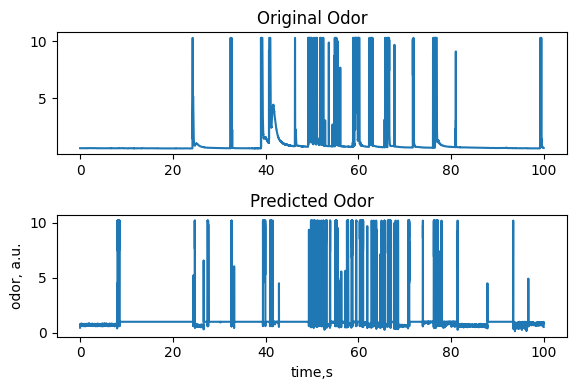

In [117]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(40,60)
# # limit = (1200,1230)
# ax1.set_xlim(limit)
# ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np

# # Define RNN Model for Dynamic Prediction
# class DynamicRNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(DynamicRNN, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x, hidden_state=None):
#         lstm_out, hidden_state = self.lstm(x, hidden_state)
#         out = self.fc(lstm_out[:, -1, :])  # Use the last hidden state
#         return self.sigmoid(out), hidden_state

# # Initialize RNN Model
# input_dim = 4  # Updated to include encounter_frequency
# hidden_dim = 64
# output_dim = 1  # Whiff flag prediction
# rnn_model = DynamicRNN(input_dim, hidden_dim, output_dim)
# rnn_model.eval()  # Start in evaluation mode

# # Initialize variables
# hidden_state = None
# current_time = 0
# last_whiff_time = 0
# odor_concentration_samples = np.full(len(df_test), base_odor_level)
# whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

# # Function for smoothing concentrations
# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data
#     window = np.ones(int(window_size)) / float(window_size)
#     return np.convolve(data, window, 'same')

# # Handle Whiff Zones Dynamically with Encounter Frequency
# i = 0
# while i < len(df_test):
#     row = df_test.iloc[i]
#     dist_along, nearest_from = row['distance_along_streakline'], row['nearest_from_streakline']
#     encounter_frequency = row['encounter_frequency']

#     # Dynamically fetch heatmap probability
#     x_bin = np.digitize([dist_along], xedges)[0] - 1
#     y_bin = np.digitize([nearest_from], yedges)[0] - 1
#     if 0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]:
#         spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
#     else:
#         spatial_prob = 0

#     # Time-based features
#     time_since_last_whiff = current_time - last_whiff_time

#     # Create feature vector (now includes encounter_frequency)
#     feature_vector = torch.tensor(
#         [[dist_along, nearest_from, spatial_prob, time_since_last_whiff]],
#         dtype=torch.float32
#     )

#     # Predict dynamically using RNN
#     with torch.no_grad():
#         prob, hidden_state = rnn_model(feature_vector.unsqueeze(0), hidden_state)
#         whiff_prob = prob.item() * 0.008  # Scale probability to avoid over-prediction

#     # Use the whiff probability directly to decide if a whiff occurs
#     if np.random.rand() < whiff_prob and np.min(distances[i]) <= distance_threshold:
#         # Whiff zone detected
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = max(1, min(duration, len(df_test) - i))  # Ensure at least 1 row is filled

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1

#         # Update temporal variables
#         last_whiff_time = current_time
#         current_time += rows_to_fill * dt
#         i += rows_to_fill
#         hidden_state = None  # Reset hidden state after a whiff
#     else:
#         # No whiff detected
#         current_time += dt
#         i += 1

# # Handle No-Whiff Zones
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#             current_time += dt
#         end = i

#         # Generate concentrations for the no-whiff zone
#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)
#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update DataFrame with results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples
